In [1]:
import matplotlib
matplotlib.use('pdf')

%pylab inline
import seaborn; seaborn.set_style('whitegrid')
from avocado import *
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = numpy.load("results.npy")

In [3]:
data_dir = '/net/noble/vol4/noble/user/jmschr/proj/avocado/data'
pred_dir = '/net/noble/vol5/user/jmschr/proj/avocado/predictions'

valid_chrom_err, valid_predictd_err = 0, 0

for celltype, assay in tqdm(validation_set):
    y_true = numpy.load('{}/{}.{}.pilot.arcsinh.npy'.format(data_dir, celltype, assay))
    y_chrom = numpy.load('{}/ChromImpute/{}.{}.pilot.imputed.npz'.format(pred_dir, celltype, assay))['arr_0']
    y_chrom = numpy.arcsinh(y_chrom)
    
    y_predictd = numpy.load('{}/PREDICTD/{}.{}.pilot.predictd.npz'.format(pred_dir, celltype, assay))['arr_0']
    
    valid_chrom_err += ((y_chrom - y_true) ** 2).mean() / 100
    valid_predictd_err += ((y_predictd - y_true) ** 2).mean() / 100

100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


In [4]:
valid_chrom_err, valid_predictd_err

(0.14503661636549425, 0.12536199984495583)

In [5]:
data_dir = '/net/noble/vol4/noble/user/jmschr/proj/avocado/data'
pred_dir = '/net/noble/vol5/user/jmschr/proj/avocado/predictions'

test_chrom_err, test_predictd_err = 0, 0

for celltype, assay in tqdm(test_set):
    y_true = numpy.load('{}/{}.{}.pilot.arcsinh.npy'.format(data_dir, celltype, assay))
    y_chrom = numpy.load('{}/ChromImpute/{}.{}.pilot.imputed.npy'.format(pred_dir, celltype, assay))
    y_chrom = numpy.arcsinh(y_chrom)
    
    y_predictd = numpy.load('{}/PREDICTD/{}.{}.pilot.predictd.npy'.format(pred_dir, celltype, assay))
    
    test_chrom_err += ((y_chrom - y_true) ** 2).mean() / 153
    test_predictd_err += ((y_predictd - y_true) ** 2).mean() / 153

100%|██████████| 153/153 [06:32<00:00,  2.57s/it]


In [6]:
test_chrom_err, test_predictd_err

(0.138705892256944, 0.11881349737225556)

In [7]:
0.1131 / 0.1188

0.9520202020202021

In [8]:
0.1119 / 0.1188

0.9419191919191919

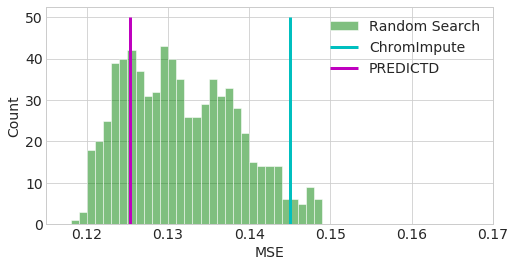

In [5]:
plt.figure(figsize=(8, 4))
#plt.title("Random Search Results on ENCODE Pilot Regions", fontsize=16)

plt.hist(data[:,7:].mean(axis=1), bins=numpy.arange(0.115, 0.150, 0.001), facecolor='g', edgecolor='w', alpha=0.5, label="Random Search")
plt.vlines([valid_chrom_err], [0], [50], color='c', linewidth=3, label="ChromImpute")
plt.vlines([valid_predictd_err], [0], [50], color='m', linewidth=3, label='PREDICTD')

plt.legend(fontsize=14)
plt.xlabel("MSE", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0.115, 0.17)
plt.savefig("Avocado-Supplement-Performances.pdf")
plt.show()

In [30]:
data[:,7:].mean(axis=1).min() / valid_predictd_err, data[:,7:].mean(axis=1).min() / valid_chrom_err

(0.9465017943075679, 0.8256532313387888)

In [28]:
data[:,7:].mean(axis=1).min()

0.11892393896367201

In [21]:
valid_predictd_err, data[:,7:].mean(axis=1).min()

(0.12564576177129508, 0.11892393896367201)

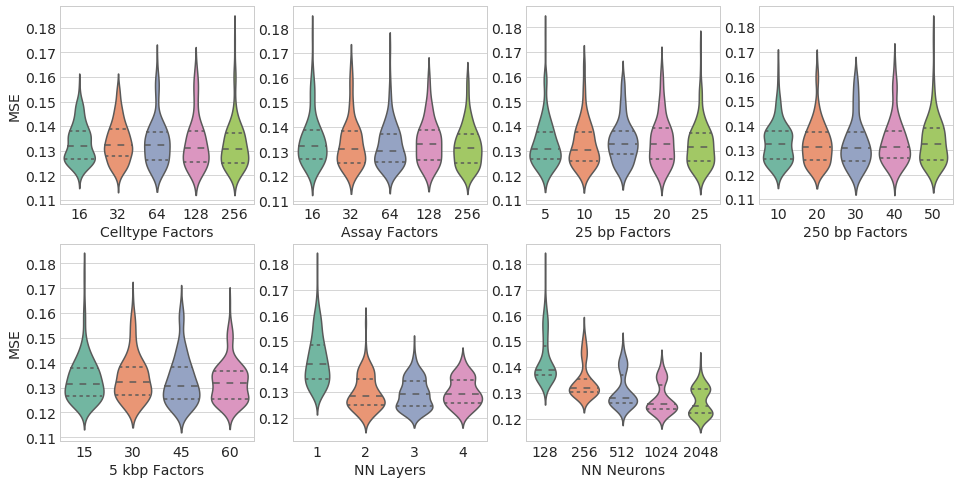

In [15]:
names = "Celltype Factors", "Assay Factors", "25 bp Factors", "250 bp Factors", "5 kbp Factors", "NN Layers", "NN Neurons"

plt.figure(figsize=(16, 8))

for i, name in enumerate(names):
    plt.subplot(2, 4, i+1)
    
    x, y = [], []
    
    for value in numpy.unique(data[:,i]).astype(int):
        subset = data[(data[:,i] == value) & (data[:,5] != 0)][:,7:].mean(axis=1)
            
        x.extend([value]*len(subset))
        y.extend(subset)

    seaborn.violinplot(x, y, alpha=0.3, palette='Set2', inner='quartile')#, bw=0.1)
    plt.xlabel(name, fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.subplot(2, 4, 1)
plt.ylabel("MSE", fontsize=14)

plt.subplot(2, 4, 5)
plt.ylabel("MSE", fontsize=14)
plt.savefig("hyperparameter_performance.pdf")

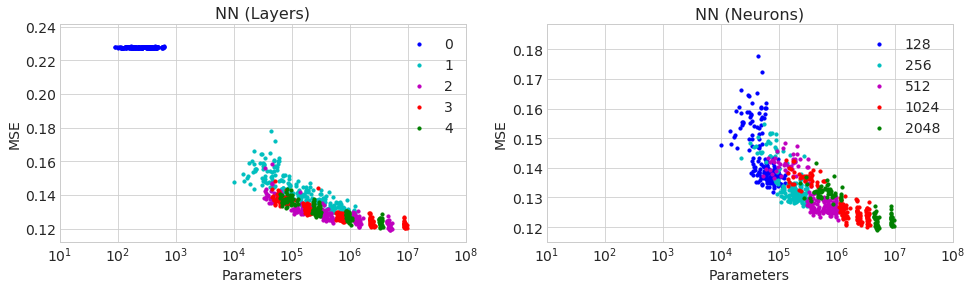

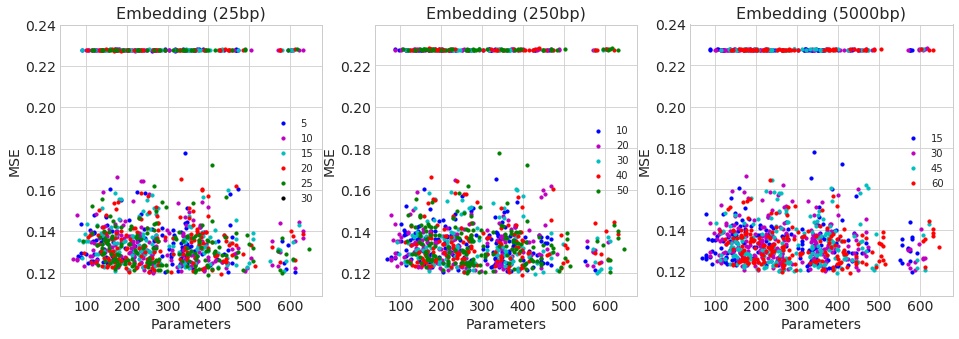

In [35]:
names = "Celltype Factors", "Assay Factors", "25 bp Factors", "250 bp Factors", "5 kbp Factors", "NN Layers", "NN Neurons"

layers = data[:,5]
neurons = data[:,6]
neurons[layers == 0] = 0

position_params = data[:,[2, 3, 4]].sum(axis=1)
tensor_params = data[:,:5].sum(axis=1)
nn_params = (tensor_params + 1) * neurons + (layers - 1) * (neurons ** 2) + (layers-1) * neurons + neurons + 1
nn_params[layers == 0] = tensor_params[layers == 0] + 1

plt.figure(figsize=(16, 4))
plt.subplot(121)
plt.title("NN (Layers)", fontsize=16)

for i in 0, 1, 2, 3, 4:
    idx = data[:,5] == i
    plt.scatter(nn_params[idx], data[idx,7:].mean(axis=1), edgecolor='bcmrg'[i], color='bcmrg'[i], s=10, label=i)

plt.xlabel("Parameters", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(10**1, 10**8)
plt.xscale('log')
plt.legend(fontsize=14)

plt.subplot(122)
plt.title("NN (Neurons)", fontsize=16)

for i, nn in enumerate([128, 256, 512, 1024, 2048]):
    idx = data[:,6] == nn
    plt.scatter(nn_params[idx], data[idx,7:].mean(axis=1), edgecolor='bcmrg'[i], color='bcmrg'[i], s=10, label=nn)
    
plt.xlabel("Parameters", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(10**1, 10**8)
plt.xscale('log')
plt.legend(fontsize=14)
plt.show()

plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.title("Embedding (25bp)", fontsize=16)
for i, n in enumerate([5, 10, 15, 20, 25, 30]):
    idx = data[:,2] == n
    plt.scatter(tensor_params[idx], data[idx,7:].mean(axis=1), s=10, color='bmcrgk'[i], label=n)
    
plt.xlabel("Parameters", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()

plt.subplot(132)
plt.title("Embedding (250bp)", fontsize=16)
for i, n in enumerate([10, 20, 30, 40, 50]):
    idx = data[:,3] == n
    plt.scatter(tensor_params[idx], data[idx,7:].mean(axis=1), s=10, color='bmcrgk'[i], label=n)
    
plt.xlabel("Parameters", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()

plt.subplot(133)
plt.title("Embedding (5000bp)", fontsize=16)
for i, n in enumerate([15, 30, 45, 60]):
    idx = data[:,4] == n
    plt.scatter(tensor_params[idx], data[idx,7:].mean(axis=1), s=10, color='bmcrg'[i], label=n)
    
plt.xlabel("Parameters", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()

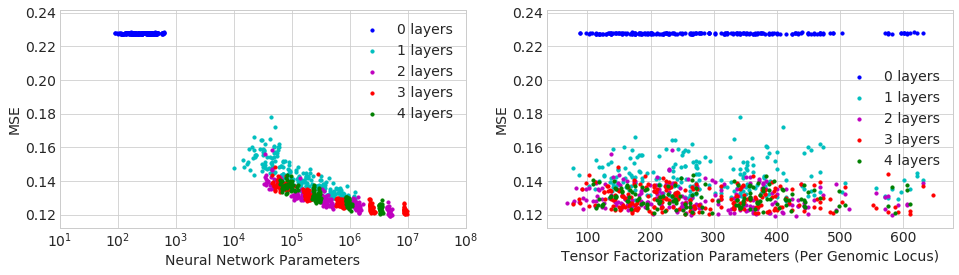

In [9]:
names = "Celltype Factors", "Assay Factors", "25 bp Factors", "250 bp Factors", "5 kbp Factors", "NN Layers", "NN Neurons"

layers = data[:,5]
neurons = data[:,6]
neurons[layers == 0] = 0

position_params = data[:,[2, 3, 4]].sum(axis=1)
tensor_params = data[:,:5].sum(axis=1)
nn_params = (tensor_params + 1) * neurons + (layers - 1) * (neurons ** 2) + (layers-1) * neurons + neurons + 1
nn_params[layers == 0] = tensor_params[layers == 0] + 1

plt.figure(figsize=(16, 4))
plt.subplot(121)
#plt.title("Neural Network Parameters", fontsize=16)

for i in 0, 1, 2, 3, 4:
    idx = data[:,5] == i
    a, b = nn_params[idx], data[idx,7:].mean(axis=1)
    plt.scatter(a, b, edgecolor='bcmrg'[i], color='bcmrg'[i], s=10, label="{} layers".format(i))

plt.xlabel("Neural Network Parameters", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(10**1, 10**8)
plt.xscale('log')
plt.legend(fontsize=14)

plt.subplot(122)
#plt.title("NN (Neurons)", fontsize=16)

for i in 0, 1, 2, 3, 4:
    idx = data[:,5] == i
    a, b = tensor_params[idx], data[idx,7:].mean(axis=1)
    plt.scatter(a, b, edgecolor='bcmrg'[i], color='bcmrg'[i], s=10, label="{} layers".format(i))

plt.xlabel("Tensor Factorization Parameters (Per Genomic Locus)", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig("Avocado_Supplement_Num_Parameters.pdf")
plt.show()

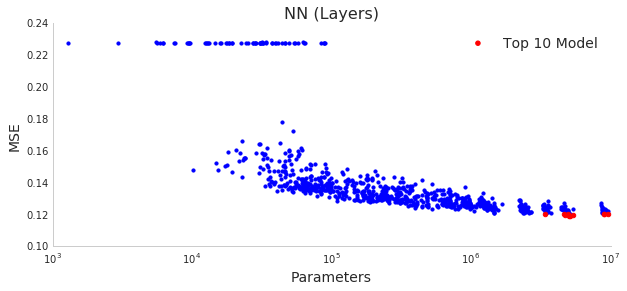

In [24]:
errors = data[:,7:].mean(axis=1)
errors = numpy.sort(errors)

top10 = data[:,7:].mean(axis=1) <= errors[9]

plt.figure(figsize=(10, 4))
plt.title("NN (Layers)", fontsize=16)

plt.scatter(nn_params[~top10], data[~top10, 7:].mean(axis=1), edgecolor='b', color='b', s=10)
plt.scatter(nn_params[top10], data[top10, 7:].mean(axis=1), edgecolor='r', color='r', s=20, label="Top 10 Model")

plt.xscale('log')
plt.xlabel("Parameters", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.legend(fontsize=14)
plt.xlim(10**3, 10**7)
plt.ylim(0.10, 0.24)
plt.yticks(numpy.arange(0.10, 0.25, 0.02))
plt.grid(False)
seaborn.despine()

In [25]:
print data[top10, :7].astype(int)
print data[top10, 7:].mean(axis=1)

[[ 256  256    5   50   45    3 2048]
 [  32  256   25   40   45    2 2048]
 [ 256   64   20   30   60    2 2048]
 [ 256   16   25   40   30    2 2048]
 [ 128   32   10   40   45    3 2048]
 [  16  128   20   10   30    2 2048]
 [  64  128    5   50   45    3 2048]
 [ 128   32   20   30   45    4 1024]
 [ 128   16   10   50   60    2 2048]
 [ 256  256   25   30   15    2 2048]]
[0.12050664 0.11892394 0.11919911 0.12031848 0.12022129 0.12044925
 0.12036891 0.120181   0.11969501 0.11966973]


In [26]:
errors = data[:,7:].mean(axis=1)
idxs = numpy.argsort(errors)
print data[idxs[:20], :7].astype(int)

[[  32  256   25   40   45    2 2048]
 [ 256   64   20   30   60    2 2048]
 [ 256  256   25   30   15    2 2048]
 [ 128   16   10   50   60    2 2048]
 [ 128   32   20   30   45    4 1024]
 [ 128   32   10   40   45    3 2048]
 [ 256   16   25   40   30    2 2048]
 [  64  128    5   50   45    3 2048]
 [  16  128   20   10   30    2 2048]
 [ 256  256    5   50   45    3 2048]
 [ 256  128    5   30   30    2 2048]
 [  64  128   20   50   45    2 2048]
 [ 256   16   20   10   60    2 2048]
 [  64   32   15   30   30    3 2048]
 [ 256  256   15   30   30    4 1024]
 [ 256  128   10   50   45    3 1024]
 [ 128   64   25   20   60    4 1024]
 [ 128   64    5   30   30    2 2048]
 [ 128  128    5   50   15    2 2048]
 [ 128   32   10   50   45    2 2048]]


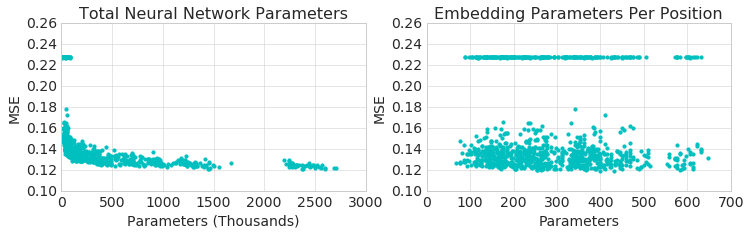

In [27]:
names = "Celltype Factors", "Assay Factors", "Position Factors", "Histone Factors", "'Regulatory' Factors", "NN Layers", "NN Neurons"

layers = data[:,5]
neurons = data[:,6]

position_params = data[:,[2, 3, 4]].sum(axis=1)
tensor_params = data[:,:5].sum(axis=1)
nn_params = (tensor_params + 1) * neurons + (layers - 1) * (neurons ** 2) + (layers-1) * neurons + neurons + 1

plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.title("Total Neural Network Parameters", fontsize=16)
plt.scatter(nn_params, data[:,7:].mean(axis=1), color='c', s=10, label=i)
plt.xlabel("Parameters (Thousands)", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(range(0, 3000001, 500000), range(0, 3001, 500), fontsize=14)
plt.xlim(0, 3000000)


plt.subplot(122)
plt.title("Embedding Parameters Per Position", fontsize=16)
plt.scatter(tensor_params, data[:,7:].mean(axis=1), s=10, color='c', label=n)
plt.xlabel("Parameters", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [34]:
names = "Celltype Factors", "Assay Factors", "25 bp Factors", "250 bp Factors", "5 kbp Factors", "NN Layers", "NN Neurons"

layers = data[:,5]
neurons = data[:,6]
neurons[layers == 0] = 0

position_params = data[:,[2, 3, 4]].sum(axis=1)
tensor_params = data[:,:5].sum(axis=1)
nn_params = (tensor_params + 1) * neurons + (layers - 1) * (neurons ** 2) + (layers-1) * neurons + neurons + 1
nn_params[layers == 0] = tensor_params[layers == 0] + 1

In [33]:
nn_params.shape, (layers == 0).shape, nn_params[layers == 0].shape, (tensor_params + 1).shape

((1000,), (1000,), (222,), (1000,))